In [2]:
import sys

import gaialab.scanner.frame_transformations as ft
from gaialab.scanner.scanner import Scanner
from gaialab.scanner.satellite import Satellite
from gaialab.scanner.source import Source

import gaialab.scanner.constants as const

import quaternion
from gaialab.scanner.agis import Agis
from gaialab.scanner.agis import Calc_source
import gaialab.scanner.agis_functions as af
import gaialab.scanner.helpers as helpers
import gaialab.scanner.analytic_plots as aplots

import numpy as np

import astropy.units as units
import matplotlib.pyplot as plt
import astropy.units as units

In [3]:
t_init = 0 
t_end =  365*5
my_dt = 1/24 # [days]
gaia = Satellite(ti=t_init, tf=t_end, dt= my_dt)
scanner = Scanner()

In [4]:
class calc_src :
    """the data structure that is used for a calculated source"""
    def __init__(self,alpha,delta,varpi,muAlphaStar,muDelta):
        self.s_params = [alpha,delta,varpi,muAlphaStar,muDelta]
        self.mu_radial = 0.0

the agis.py code is not that simple, basic functionalities such as source solver are not obvious, below is a proposal for changes.

In [5]:
def compute_du_ds(p,q,r,q_l,t_l):
    """
    params p,q,r : the vectors defining the frame associated to a source position at reference epoch
    params q_l,t_l : the attitude at time t_l
    returns : du_ds_SRS
    """
    # Equation 73
    r.shape = (3, 1)  # reshapes r
    b_G = gaia.ephemeris_bcrs(t_l)
    tau = t_l - const.t_ep  # + np.dot(r, b_G) / const.c
    # Compute derivatives
    du_ds_CoMRS = [p, q, af.compute_du_dparallax(r, b_G), p*tau, q*tau]
    # Equation 72
    # should be changed to a pythonic map
    du_ds_SRS = []
    for derivative in du_ds_CoMRS:
        du_ds_SRS.append(ft.lmn_to_xyz(q_l, derivative))
    return np.array(du_ds_SRS)

def computeScanAngle(p0,q0,z):
    """
    Compute the scan direction theta = atan2(q0'z, -p0'z) 
    param p0 : local East (increasing alpha) 
    param q0 : local North (increasing delta if |delta_0|<90) 
    param z : unit vector z obtained from the attitude quaternion at the time of transit
    See equation (1) in LL-061 and equation (13)
    """
    return np.atan2(q0@z,-p0@z)

def compute_design_equation(true_source,calc_source,observation_times):
    """
    param true_source : the parameters of the true source
    param calc_source : the parameters of the estimated source
    param observation_times : scanner observation times
    returns : dR_ds_AL, dR_ds_AC, R_AL, R_AC, FA(phi_obs, zeta_obs,phi_calc, zeta_calc)
    """
    alpha0 = calc_source.s_params[0]
    delta0 = calc_source.s_params[1]    
    p0, q0, r0 = ft.compute_pqr(alpha0, delta0)
    n_obs = len(observation_times)
    R_AL = np.zeros(n_obs)
    R_AC = np.zeros(n_obs)
    dR_ds_AL = np.zeros((n_obs, 5))
    dR_ds_AC = np.zeros((n_obs, 5))
    FA = []
    for j, t_l in enumerate(observation_times): 
        # one should use the 2 telescopes option for the residuals
        q_l = gaia.func_attitude(t_l)
        phi_obs, zeta_obs = af.observed_field_angles(true_source, q_l, gaia, t_l, True)
        phi_calc, zeta_calc = af.calculated_field_angles(calc_source, q_l, gaia, t_l, True)
        
        FA.append([phi_obs, zeta_obs,phi_calc, zeta_calc])
        
        R_AL[j] = (phi_obs-phi_calc)
        R_AC[j] = (zeta_obs-zeta_calc)
        
        # but not for the derivatives...
        phi_c, zeta_c = af.calculated_field_angles(calc_source, q_l, gaia, t_l, False)
        m, n, u = af.compute_mnu(phi_c, zeta_c)
        
        du_ds = compute_du_ds(p0,q0,r0,q_l,t_l)
        dR_ds_AL[j, :] = m @ du_ds.transpose() * helpers.sec(zeta_calc)
        dR_ds_AC[j, :] = n @ du_ds.transpose()
    return dR_ds_AL, dR_ds_AC, R_AL, R_AC, np.array(FA)

def solve_AL(true_source,calc_source,observation_times):
    """
    perform one step of the source solver using only along scan observations
    """
    # get the design equation
    dR_ds_AL, dR_ds_AC, R_AL, R_AC, FA = compute_design_equation(true_source,calc_source,observation_times)
    # build the normal equation
    N = dR_ds_AL.transpose() @ dR_ds_AL 
    rhs = dR_ds_AL.transpose() @ R_AL
    # solve the normal equation
    updates = np.linalg.solve(N,rhs)
    # update the calculated source parameters
    # take care of alpha
    calc_source.s_params[0] = calc_source.s_params[0] + updates[0] * np.cos(calc_source.s_params[1])
    calc_source.s_params[1:] = calc_source.s_params[1:] + updates[1:]

the source model might need some clarification

In [6]:
zero_color = lambda t: 0
sirio = Source("sirio", 101.28, -16.7161, 379.21, -546.05, -1223.14, 0, func_color=zero_color, mean_color=0 )

In [7]:
scanner.scan(gaia, sirio, t_init, t_end)
scanner.compute_angles_eta_zeta(gaia, sirio)
scanner_observation_times = scanner.obs_times

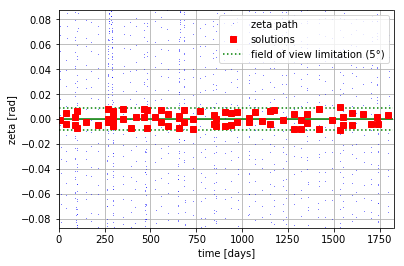

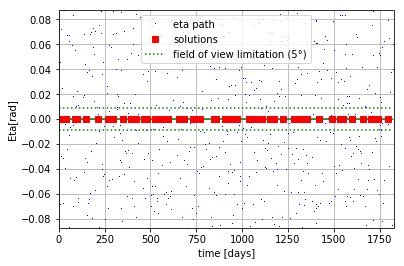

In [8]:
aplots.plot_field_angles(source=sirio, sat=gaia, obs_times=scanner.obs_times, ti=t_init, tf=t_end, 
                  n=10000, limit=True, double_telescope=True);

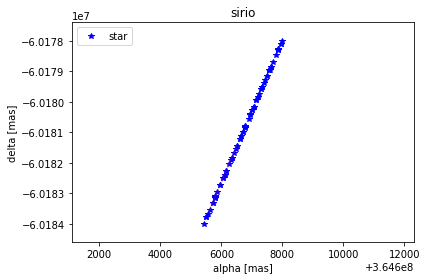

In [9]:
aplots.plot_star(source=sirio, satellite=gaia, obs_times=scanner.obs_times);

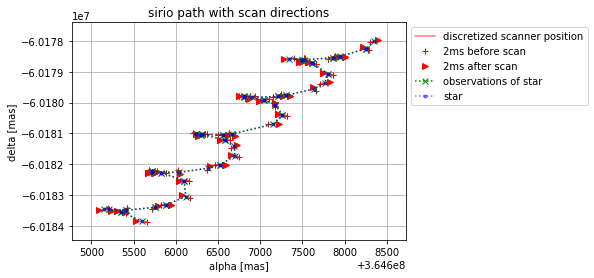

In [10]:
aplots.plot_star_trajectory_with_scans(sat=gaia, source=sirio, obs_times=scanner.obs_times, 
                                      num_ms_for_snapshot=2);

In [11]:
def noise_calc_sources(s,noise = 1e-5):
    """
    add noise to source parameters
    """
    s.s_params[0] += noise
    s.s_params[1] += noise
    s.s_params[2] += -s.s_params[2]/10
    s.s_params[3] += s.s_params[3]*0.1
    s.s_params[4] += s.s_params[4]*0.1

The mode updating set to 'source' means that one used a non realistic attitude for each observation time based on the source position. The documentation should be updated to be clearer.

In [12]:
calc_s =  Calc_source(obs_times=scanner_observation_times, source=sirio, mean_color=sirio.mean_color)
noise_calc_sources(calc_s)
calc_s.s_params-sirio.get_parameters()[:5]

array([ 1.00000000e-05,  1.00000000e-05, -1.83846196e-07, -6.94644842e-10,
       -1.62464385e-09])

The field angles values computed in *compute_design_equation* can be used to visualised the source position in the sky as seen in the SRS reference frame associated to the satellite.

In [13]:
dR_ds_AL, dR_ds_AC, R_AL, R_AC, FA = compute_design_equation(sirio,calc_s,scanner_observation_times)  

for the true source

In [14]:
np.sqrt(R_AL@R_AL)

7.418549260943013e-05

One can check that the solver is converging after 10 iterations of the source update.

In [15]:
for i in range(0,10):
    solve_AL(sirio,calc_s,scanner_observation_times)
    calc_s.s_params-sirio.get_parameters()[:5]

In [16]:
dR_ds_AL, dR_ds_AC, R_AL, R_AC, FA = compute_design_equation(sirio,calc_s,scanner_observation_times)  

In [17]:
np.sqrt(R_AL@R_AL)

1.6910413304902302e-15